## 1. Dataset Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adelfr2009/ip102-new --unzip --force # download data

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/adelfr2009/ip102-new
License(s): unknown
 98% 3.63G/3.70G [00:09<00:00, 800MB/s] 
100% 3.70G/3.70G [00:09<00:00, 412MB/s]


In [ ]:
import os
import shutil
from tqdm import tqdm

# Paths
base_dir = "/content/ip102/Classification"
images_dir = os.path.join(base_dir, "images")
output_dir = "/content/ip102dataset"

# Include test split
splits = {
    "train": os.path.join(base_dir, "train.txt"),
    "val": os.path.join(base_dir, "val.txt"),
    "test": os.path.join(base_dir, "test.txt"),
}

# Process each split
for split, split_file in splits.items():
    if not os.path.exists(split_file):
        print(f"Missing file: {split_file}")
        continue

    with open(split_file, "r") as f:
        lines = f.readlines()

    print(f"Processing {split} set ({len(lines)} images)...")

    for line in tqdm(lines, desc=f"Copying {split}"):
        img_name, class_id = line.strip().split()
        src = os.path.join(images_dir, img_name)
        dst_dir = os.path.join(output_dir, split, f"class{class_id}")
        dst = os.path.join(dst_dir, img_name)

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src):
            shutil.copy2(src, dst)
        else:
            print(f"Image not found: {src}")


Processing train set (45095 images)...


Copying train: 100%|██████████| 45095/45095 [00:06<00:00, 7287.26it/s]


Processing val set (7508 images)...


Copying val: 100%|██████████| 7508/7508 [00:01<00:00, 7360.04it/s]


Processing test set (22619 images)...


Copying test: 100%|██████████| 22619/22619 [00:03<00:00, 7299.56it/s]


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Reserved GPU Memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print(f"Allocated GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    # أو استعمل:
    # print(torch.cuda.memory_summary(device=None, abbreviated=False))
else:
    print("CUDA not available.")

Total GPU Memory: 39.56 GB
Reserved GPU Memory: 0.00 GB
Allocated GPU Memory: 0.00 GB


## 2. Traning  model

In [ ]:
import argparse
import time
import yaml
import os
import glob
import math
import logging
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.utils
from torch.nn.parallel import DistributedDataParallel as NativeDDP

from timm.data import (
    create_dataset,
    create_loader,
    resolve_data_config,
    Mixup,
    FastCollateMixup,
    AugMixDataset,
)
from timm.models import (
    create_model,
    safe_model_name,
    resume_checkpoint,
    load_checkpoint,
    model_parameters,
)
from timm.layers import convert_splitbn_model
from timm.utils import *
from timm.loss import *
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm.scheduler import create_scheduler
from timm.utils import ApexScaler, NativeScaler
from torch.nn import functional as F
#from misc.cosine_annealing import CosineWDSchedule

In [ ]:

torch.backends.cudnn.benchmark = True
_logger = logging.getLogger("train")

EPOCHS = 120
OPTIMIZER = 'adamw'
LEARNING_RATE = 5e-4
BATCH_SIZE = 384
MODEL = "fastvit_sa12"
PRETRAINED = False



NUM_CLASSES = 102
DROP = 0.3
DROP_PATH = 0.1
INITIAL_CHECKPOINT = '' #'/content/drive/MyDrive/best_fastvit_distill-v1.pth.tar' #""
WEIGHT_DECAY = 0.05
WD_SCHEDULE = None
MODEL_EMA_DECAY = 0.9995
USE_PREFETCHER = False
SCHED = 'cosine'
PATIENCE_EPOCHS = 8
TEACHER_PATH = "/content/drive/MyDrive/regnety160_ip102.pth.tar"
TEACHER_MODEL = "regnety_160"
DATASET_DIR = "/content/ip102dataset"
WORKERS = 8
EVAL_METRIC = "top1"
OUTPUT = "/content/ip102dataset_results"
CHECKPOINT_HIST = 5
SAVE_IMAGES = True

JSD_LOSS = False
BCE_LOSS = False
BCE_TARGET_THRESH = None
CLIP_GRAD = None
CLIP_MODE = 'norm'


MIXUP = 0.2
CUTMIX = 1.0
MIXUP_PROB = 0.5
MIXUP_SWITCH_PROB = 0.3
MIXUP_MODE = "batch"
MIXUP_OFF_EPOCH = 0
CUTMIX_MINMAX = None
SMOOTHING = 0.1
REPROB = 0.25
REMODE = "pixel"
RECOUNT = 1
RESPLIT = False
SCALE = [0.7, 1.0]
RATIO = [0.75, 1.33]
HFLIP = 0.5
VFLIP = 0.0
COLOR_JITTER = 0.4
AA = "rand-m9-mstd0.5-inc1"
AUG_REPEATS = 0.0
TTA = 0

DISTILLATION_TYPE = "soft"
DISTILLATION_ALPHA = 0.5
DISTILLATION_TAU = 4.0#1.0

TRAIN_INTERPOLATION = 'random'

In [ ]:
def train_one_epoch(
    epoch,
    model,
    loader,
    optimizer,
    loss_fn,
    lr_scheduler=None,
    saver=None,
    output_dir=None,
    amp_autocast=suppress,
    loss_scaler=None,
    model_ema=None,
    mixup_fn=None,
    wd_scheduler=None,
):

    if MIXUP_OFF_EPOCH and epoch >= MIXUP_OFF_EPOCH:
        if USE_PREFETCHER and loader.mixup_enabled:
            loader.mixup_enabled = False
        elif mixup_fn is not None:
            mixup_fn.mixup_enabled = False

    second_order = hasattr(optimizer, "is_second_order") and optimizer.is_second_order
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()

    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    for batch_idx, (input, target) in enumerate(loader):
        last_batch = batch_idx == last_idx
        data_time_m.update(time.time() - end)
        if not USE_PREFETCHER:
            input, target = input.cuda(), target.cuda()
            if mixup_fn is not None:
                input, target = mixup_fn(input, target)

        with amp_autocast():
            output = model(input)
            loss = loss_fn(input, output, target)

        losses_m.update(loss.item(), input.size(0))
        optimizer.zero_grad()
        if loss_scaler is not None:
            loss_scaler(
                loss,
                optimizer,
                clip_grad=CLIP_GRAD,
                clip_mode=CLIP_MODE,
                parameters=model_parameters(
                    model, exclude_head="agc" in CLIP_MODE
                ),
                create_graph=second_order,
            )
        else:
            loss.backward(create_graph=second_order)
            if CLIP_GRAD is not None:
                dispatch_clip_grad(
                    model_parameters(model, exclude_head="agc" in CLIP_MODE),
                    value=CLIP_GRAD,
                    mode=CLIP_MODE,
                )
            optimizer.step()

        if model_ema is not None:
            model_ema.update(model)

        torch.cuda.synchronize()
        num_updates += 1
        batch_time_m.update(time.time() - end)
        if last_batch or batch_idx % 50 == 0:
            lrl = [param_group["lr"] for param_group in optimizer.param_groups]
            lr = sum(lrl) / len(lrl)
            wd0 = list(optimizer.param_groups)[0]["weight_decay"]
            wd1 = list(optimizer.param_groups)[1]["weight_decay"]
            _logger.info(
                "Train: {} [{:>4d}/{} ({:>3.0f}%)]  "
                "Loss: {loss.val:#.4g} ({loss.avg:#.3g})  "
                "Time: {batch_time.val:.3f}s, {rate:>7.2f}/s  "
                "({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  "
                "LR: {lr:.3e}, WD0: {wd0:.6e}, WD1: {wd1:.6e}    "
                "Data: {data_time.val:.3f} ({data_time.avg:.3f})".format(
                    epoch,
                    batch_idx,
                    len(loader),
                    100.0 * batch_idx / last_idx,
                    loss=losses_m,
                    batch_time=batch_time_m,
                    rate=input.size(0) * 1 / batch_time_m.val,
                    rate_avg=input.size(0) * 1 / batch_time_m.avg,
                    lr=lr,
                    wd0=wd0,
                    wd1=wd1,
                    data_time=data_time_m,
                )
            )
            if SAVE_IMAGES and output_dir:
                torchvision.utils.save_image(
                    input,
                    os.path.join(output_dir, "train-batch-%d.jpg" % batch_idx),
                    padding=0,
                    normalize=True,
                )

        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)

        end = time.time()
        # end for

    if hasattr(optimizer, "sync_lookahead"):
        optimizer.sync_lookahead()

    return OrderedDict([("loss", losses_m.avg)])


def validate(model, loader, loss_fn, amp_autocast=suppress, log_suffix=""):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx
            if not USE_PREFETCHER:
                input = input.cuda()
                target = target.cuda()

            with amp_autocast():
                output = model(input)
            if isinstance(output, (tuple, list)):
                output = output[0]

            # augmentation reduction
            reduce_factor = TTA
            if reduce_factor > 1:
                output = output.unfold(0, reduce_factor, reduce_factor).mean(dim=2)
                target = target[0 : target.size(0) : reduce_factor]

            loss = loss_fn(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))


            reduced_loss = loss.data

            torch.cuda.synchronize()

            losses_m.update(reduced_loss.item(), input.size(0))
            top1_m.update(acc1.item(), output.size(0))
            top5_m.update(acc5.item(), output.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()
            if last_batch or batch_idx % 50 == 0:
              log_name = "Test" + log_suffix
              _logger.info(
                  "{0}: [{1:>4d}/{2}]  "
                  "Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  "
                  "Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  "
                  "Acc@1: {top1.val:>7.4f} ({top1.avg:>7.4f})  "
                  "Acc@5: {top5.val:>7.4f} ({top5.avg:>7.4f})".format(
                      log_name,
                      batch_idx,
                      last_idx,
                      batch_time=batch_time_m,
                      loss=losses_m,
                      top1=top1_m,
                      top5=top5_m,
                    )
                )

    metrics = OrderedDict(
        [("loss", losses_m.avg), ("top1", top1_m.avg), ("top5", top5_m.avg)]
    )

    return metrics


class DistillationLoss(torch.nn.Module):
    """
    This module wraps a standard criterion and adds an extra knowledge distillation loss by
    taking a teacher model prediction and using it as additional supervision.
    """

    def __init__(
        self,
        base_criterion: torch.nn.Module,
        teacher_model: torch.nn.Module,
        distillation_type: str,
        alpha: float,
        tau: float,
    ):
        super().__init__()
        self.base_criterion = base_criterion
        self.teacher_model = teacher_model
        assert distillation_type in ["none", "soft", "hard"]
        self.distillation_type = distillation_type
        self.alpha = alpha
        self.tau = tau

    def forward(self, inputs, outputs, labels):
        """
        Args:
            inputs: The original inputs that are feed to the teacher model.
            outputs: Output tensor from model being trained.
            labels: the labels for the base criterion.
        """
        base_loss = self.base_criterion(outputs, labels)
        if self.distillation_type == "none":
            return base_loss

        # don't backprop throught the teacher
        with torch.no_grad():
            teacher_outputs = self.teacher_model(inputs)

        if self.distillation_type == "soft":
            T = self.tau
            # taken from https://github.com/peterliht/knowledge-distillation-pytorch/blob/master/model/net.py#L100
            # with slight modifications
            distillation_loss = (
                F.kl_div(
                    F.log_softmax(outputs / T, dim=1),
                    # We provide the teacher's targets in log probability because we use log_target=True
                    # (as recommended in pytorch https://github.com/pytorch/pytorch/blob/9324181d0ac7b4f7949a574dbc3e8be30abe7041/torch/nn/functional.py#L2719)
                    # but it is possible to give just the probabilities and set log_target=False. In our experiments we tried both.
                    F.log_softmax(teacher_outputs / T, dim=1),
                    reduction="sum",
                    log_target=True,
                )
                * (T * T)
                / outputs.numel()
            )
            # We divide by outputs_kd.numel() to have the legacy PyTorch behavior.
            # But we also experiments output_kd.size(0)
            # see issue 61(https://github.com/facebookresearch/deit/issues/61) for more details
        elif self.distillation_type == "hard":
            distillation_loss = F.cross_entropy(outputs, teacher_outputs.argmax(dim=1))

        loss = base_loss * (1 - self.alpha) + distillation_loss * self.alpha
        return loss


In [ ]:







random_seed(42)
setup_default_logging()


model = create_model(
    MODEL,
    pretrained=PRETRAINED,
    num_classes=NUM_CLASSES,
    drop_rate=DROP,
    drop_connect_rate=None,  # DEPRECATED, use drop_path
    drop_path_rate=DROP_PATH,
    drop_block_rate=None,
    global_pool=None,
    bn_momentum=None,
    bn_eps=None,
    scriptable=False,
    checkpoint_path=INITIAL_CHECKPOINT,
)

_logger.info(f"Model {safe_model_name(MODEL)} created, param count:{sum([m.numel() for m in model.parameters()])}")

data_config = resolve_data_config(
    model.pretrained_cfg, model=model, verbose=True
)  # narja3alha hadi !!!








# setup augmentation batch splits for contrastive loss or split bn
num_aug_splits = 0


# move model to GPU, enable channels last layout if set
model.cuda()

optimizer = create_optimizer_v2(model, opt=OPTIMIZER, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


# only if native amp is supported
amp_autocast = torch.cuda.amp.autocast
loss_scaler = NativeScaler()
_logger.info("Using native Torch AMP. Training in mixed precision.")


# RESUME TRAINING
# # if resmume without fine tuning
# resume_epoch = resume_checkpoint(
#     model,
#     "pth.tar checkpoint file",
#     optimizer=optimizer, # or None
#     loss_scaler=loss_scaler, # or None
#     log_info=True)
# # if resume with fine tuning
# print("Finetune option selected, not loading optimizer state and loss_scaler")
# _ = resume_checkpoint(model, " ... path", log_info=True)
# data_config["crop_pct"] = 1.0
# print("data config: {}".format(data_config))


# EMA MODEL CONFIG
# Important to create EMA model after cuda(), DP wrapper, and AMP but before SyncBN and DDP wrapper
model_ema = ModelEmaV2(model, decay=MODEL_EMA_DECAY, device=None)
# Do not load EMA model when running in finetuning mode
#cload_checkpoint(model_ema.module, "pth.tar checkpoint file", use_ema=True) # only if resume without fine tuning


# LR SCHEDULE
# setup learning rate schedule and starting epoch


from types import SimpleNamespace

lr_scheduler_args = SimpleNamespace(
    sched=SCHED,
    num_epochs=EPOCHS,
    patience_epochs=PATIENCE_EPOCHS,
    decay_epochs=100,
    warmup_epochs=3,
    cooldown_epochs=10,
    cycle_decay=0.5,
    plateau_mode='max'
)



lr_scheduler, num_epochs = create_scheduler(
    optimizer=optimizer,
    args=lr_scheduler_args)

start_epoch = 0
if lr_scheduler is not None and start_epoch > 0:
    lr_scheduler.step(start_epoch)
_logger.info("Scheduled epochs: {}".format(num_epochs))


# setup weight decay scheduler
wd_scheduler = None
imagenet_trainset_size = 1281167 # Size of imagenet training set for weight decay scheduling.
# if WD_SCHEDULE == "cosine":
#     wd_scheduler = CosineWDSchedule(optimizer=optimizer, eta_min=WEIGHT_DECAY * 0.1,
#                                     t_max=int(EPOCHS * imagenet_trainset_size // BATCH_SIZE))

# DISTILLATION
teacher_model = None
# Instantiate teacher model, if distillation is requested.
# print(f"Creating teacher model: {TEACHER_MODEL}")
teacher_model = create_model(
    TEACHER_MODEL,
    pretrained=False,
    num_classes=NUM_CLASSES,
    global_pool="avg",
)
checkpoint = torch.load(TEACHER_PATH, map_location="cpu", weights_only=False)
teacher_model.load_state_dict(checkpoint["state_dict_ema"])

teacher_model.cuda()
teacher_model.eval()


# create the train and eval datasets


dataset_train = create_dataset(
    "IP102train",
    root=DATASET_DIR,
    split="train",
    is_training=True,
    batch_size=BATCH_SIZE,
    repeats=0.0,
)
dataset_eval = create_dataset(
    "IP102val",
    root=DATASET_DIR,
    split="validation",
    is_training=False,
    batch_size=BATCH_SIZE,
)



# setup mixup / cutmix
collate_fn = None
mixup_fn = None
mixup_active = MIXUP > 0 or CUTMIX > 0.0 or CUTMIX_MINMAX is not None
if mixup_active:
    mixup_args = dict(
        mixup_alpha=MIXUP,
        cutmix_alpha=CUTMIX,
        cutmix_minmax=CUTMIX_MINMAX,
        prob=MIXUP_PROB,
        switch_prob=MIXUP_SWITCH_PROB,
        mode=MIXUP_MODE,
        label_smoothing=SMOOTHING,
        num_classes=NUM_CLASSES,
    )
    #collate_fn = FastCollateMixup(**mixup_args) # or use:
    mixup_fn = Mixup(**mixup_args)


print("Building loader...")


# create data loaders w/ augmentation pipeiine
train_interpolation = TRAIN_INTERPOLATION
loader_train = create_loader(
    dataset_train,
    input_size=data_config["input_size"],
    batch_size=BATCH_SIZE,
    is_training=True,
    use_prefetcher=USE_PREFETCHER,
    re_prob=REPROB,
    re_mode=REMODE,
    re_count=RECOUNT,
    re_split=RESPLIT,
    scale=SCALE,
    ratio=RATIO,
    hflip=HFLIP,
    vflip=VFLIP,
    color_jitter=COLOR_JITTER,
    auto_augment=AA,
    num_aug_repeats=AUG_REPEATS,
    num_aug_splits=num_aug_splits,
    interpolation=train_interpolation,
    mean=data_config["mean"],
    std=data_config["std"],
    num_workers=WORKERS,
    distributed=False,
    collate_fn=collate_fn,
    pin_memory=True,
    worker_seeding="all",
)

loader_eval = create_loader(
    dataset_eval,
    input_size=data_config["input_size"],
    batch_size=BATCH_SIZE,
    is_training=False,
    use_prefetcher=USE_PREFETCHER,
    interpolation=data_config["interpolation"],
    mean=data_config["mean"],
    std=data_config["std"],
    num_workers=WORKERS,
    distributed=False,
    crop_pct=data_config["crop_pct"],
    pin_memory=True,
)

print("Loader built successfully.")


# setup loss function
if JSD_LOSS:
    assert num_aug_splits > 1  # JSD only valid with aug splits set
    train_loss_fn = JsdCrossEntropy(
        num_splits=num_aug_splits, smoothing=SMOOTHING
    )
elif mixup_active:
    # smoothing is handled with mixup target transform which outputs sparse, soft targets
    if BCE_LOSS:
        train_loss_fn = BinaryCrossEntropy(target_threshold=BCE_TARGET_THRESH)
    else:
        train_loss_fn = SoftTargetCrossEntropy()
elif SMOOTHING:
    if BCE_LOSS:
        train_loss_fn = BinaryCrossEntropy(
            smoothing=SMOOTHING, target_threshold=BCE_TARGET_THRESH
        )
    else:
        train_loss_fn = LabelSmoothingCrossEntropy(smoothing=SMOOTHING)
else:
    train_loss_fn = nn.CrossEntropyLoss()

train_loss_fn = train_loss_fn.cuda()
validate_loss_fn = nn.CrossEntropyLoss().cuda()

# use distill loss wrapper, which returns base loss when distillation is disabled
train_loss_fn = DistillationLoss(
    train_loss_fn,
    teacher_model,
    DISTILLATION_TYPE,
    DISTILLATION_ALPHA,
    DISTILLATION_TAU,
)

# setup checkpoint saver and eval metric tracking
eval_metric = EVAL_METRIC
best_metric = None
best_epoch = None
saver = None
output_dir = None
exp_name = "-".join(
    [
        datetime.now().strftime("%Y%m%d-%H%M%S"),
        safe_model_name(MODEL),
        str(data_config["input_size"][-1]),
    ]
)
output_dir = get_outdir(OUTPUT, exp_name)
decreasing = True if eval_metric == "loss" else False
saver = CheckpointSaver(
    model=model,
    optimizer=optimizer,
    args=None,
    model_ema=model_ema,
    amp_scaler=loss_scaler,
    checkpoint_dir=output_dir,
    recovery_dir=output_dir,
    decreasing=decreasing,
    max_history=CHECKPOINT_HIST,
)


try:
    for epoch in range(start_epoch, num_epochs):

        train_metrics = train_one_epoch(
            epoch,
            model,
            loader_train,
            optimizer,
            train_loss_fn,
            lr_scheduler=lr_scheduler,
            saver=saver,
            output_dir=output_dir,
            amp_autocast=amp_autocast,
            loss_scaler=loss_scaler,
            model_ema=model_ema,
            mixup_fn=mixup_fn,
            wd_scheduler=None,
        )



        eval_metrics = validate(
            model, loader_eval, validate_loss_fn, amp_autocast=amp_autocast
        )

        ema_eval_metrics = validate(
            model_ema.module,
            loader_eval,
            validate_loss_fn,
            amp_autocast=amp_autocast,
            log_suffix=" (EMA)",
        )
        eval_metrics = ema_eval_metrics

        if lr_scheduler is not None:
            # step LR for next epoch
            lr_scheduler.step(epoch + 1, eval_metrics[eval_metric])

        if output_dir is not None:
            update_summary(
                epoch,
                train_metrics,
                eval_metrics,
                os.path.join(output_dir, "summary.csv"),
                write_header=best_metric is None,
            )

        if saver is not None:
            # save proper checkpoint with eval metric
            save_metric = eval_metrics[eval_metric]
            best_metric, best_epoch = saver.save_checkpoint(
                epoch, metric=save_metric
            )

except KeyboardInterrupt:
    pass
if best_metric is not None:
    _logger.info("*** Best metric: {0} (epoch {1})".format(best_metric, best_epoch))




INFO:train:Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
Model fastvit_sa12 created, param count:10660518
INFO:timm.data.config:Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
Data processing configuration for current model + data

Building loader...
Loader built successfully.


<ipython-input-28-9e537a3a2bbf>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp_autocast():
INFO:train:Train: 0 [   0/117 (  0%)]  Loss: 2.332 (2.33)  Time: 6.427s,   59.75/s  (6.427s,   59.75/s)  LR: 1.000e-05, WD0: 0.000000e+00, WD1: 5.000000e-02    Data: 5.484 (5.484)
Train: 0 [   0/117 (  0%)]  Loss: 2.332 (2.33)  Time: 6.427s,   59.75/s  (6.427s,   59.75/s)  LR: 1.000e-05, WD0: 0.000000e+00, WD1: 5.000000e-02    Data: 5.484 (5.484)
Train: 0 [   0/117 (  0%)]  Loss: 2.332 (2.33)  Time: 6.427s,   59.75/s  (6.427s,   59.75/s)  LR: 1.000e-05, WD0: 0.000000e+00, WD1: 5.000000e-02    Data: 5.484 (5.484)
Train: 0 [   0/117 (  0%)]  Loss: 2.332 (2.33)  Time: 6.427s,   59.75/s  (6.427s,   59.75/s)  LR: 1.000e-05, WD0: 0.000000e+00, WD1: 5.000000e-02    Data: 5.484 (5.484)
Train: 0 [   0/117 (  0%)]  Loss: 2.332 (2.33)  Time: 6.427s,   59.75/s  (6.427s,   59.75/s)  LR: 1.000e-05, WD0: 0.000000e+00, WD1

In [ ]:
!cp /content/ip102dataset_results/20250531-111550-fastvit_sa12-256/model_best.pth.tar /content/drive/MyDrive/best_fastvit_distill-v1.pth.tar

cp: cannot stat '/content/ip102dataset_results/20250531-111550-fastvit_sa12-256/model_best.pth.tar': No such file or directory


In [ ]:
!cp /content/ip102dataset_results/20250531-111550-fastvit_sa12-256/summary.csv /content/drive/MyDrive/summary_fastvit_distill-v1.pth.tar

INFO:numexpr.utils:NumExpr defaulting to 12 threads.
NumExpr defaulting to 12 threads.


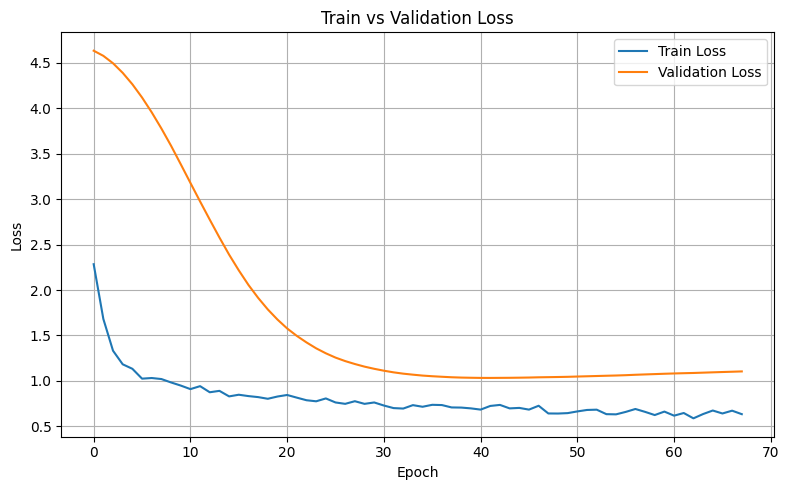

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('/content/ip102dataset_results/20250531-111550-fastvit_sa12-256/summary.csv')

# Plot Loss vs Validation Loss (no points)
plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['eval_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 3. Testing model

In [ ]:
import copy
import torch
import torch.nn as nn

def reparameterize_model(model: torch.nn.Module) -> nn.Module:
    """Method returns a model where a multi-branched structure
        used in training is re-parameterized into a single branch
        for inference.

    Args:
        model: MobileOne model in train mode.

    Returns:
        MobileOne model in inference mode.
    """
    # Avoid editing original graph
    model = copy.deepcopy(model)
    for module in model.modules():
        if hasattr(module, "reparameterize"):
            module.reparameterize()
    return model

def get_model_size(model):
  # Save temporarily and measure size
  torch.save(model.state_dict(), "temp_model.pth")
  import os
  size_mb = os.path.getsize("temp_model.pth") / (1024 * 1024)
  # Optional: remove temp file
  os.remove("temp_model.pth")
  return size_mb

In [ ]:
import torch
from timm.models import create_model

# Step 1: Create the same model architecture
model = create_model(
    "fastvit_sa12",
    pretrained=False,
    num_classes=102,
)



# Step 2: Load your trained checkpoint
checkpoint = torch.load('/content/ip102dataset_results/20250531-111550-fastvit_sa12-256/model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

# Step 3: Switch to evaluation mode and reparameterize
#model.eval()
#model_inf = reparameterize_model(model).cuda()  # if using GPU
model.cuda()
model.eval()
print("")

In [ ]:
import torch
from timm.models import create_model
from timm.utils import  accuracy, AverageMeter
# Step 1: Create the same model architecture
model = create_model(
    "fastvit_sa12",
    pretrained=False,
    num_classes=102,
)



# Step 2: Load your trained checkpoint
checkpoint = torch.load('/content/ip102dataset_results/20250531-111550-fastvit_sa12-256/model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

# Step 3: Switch to evaluation mode and reparameterize
#model.eval()
#model_inf = reparameterize_model(model).cuda()  # if using GPU
model.cuda()
model.eval()
model  = reparameterize_model(model)

from timm.data import resolve_data_config, create_transform

config = resolve_data_config({}, model=model)

transform = create_transform(**config)

from torchvision import datasets
import re
from torch.utils.data import DataLoader
from timm.data import create_dataset

dataset_test = create_dataset(
    "IP102val",
    root="/content/ip102dataset",
    split="test",
    is_training=False,
    batch_size=128,
    transform=transform,
)


loader = DataLoader(
    dataset_test,
    batch_size=512,
    shuffle=False,            # shuffle=False == evaluation
    num_workers=2,
    pin_memory=False
)



In [ ]:
# ----------------------------
# Inference & Evaluation
# ----------------------------
import torch.nn.functional as F

correct = 0
total = 0
top1 = AverageMeter()

all_preds = []
all_labels = []
probs = []

with torch.no_grad():
    for images, labels in tqdm(loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc1 = accuracy(outputs, labels, topk=(1,))[0]
        top1.update(acc1.item(), images.size(0))
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        softmax_probs = F.softmax(outputs, dim=1)
        max_probs, pred = softmax_probs.max(dim=1)
        probs.extend(max_probs.cpu().numpy())


100%|██████████| 45/45 [01:31<00:00,  2.03s/it]


In [ ]:
accuracy_final = 100 * correct / total
print(f"\n✅ Top-1 Accuracy: {accuracy_final:.2f}%")



✅ Top-1 Accuracy: 73.41%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

report = classification_report(all_labels, all_preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Optional: save to CSV
df_report.to_csv("classification_report.csv")
# عرض كامل بدون تقطيع
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

df_report

,precision,recall,f1-score,support
0,0.661578,0.776119,0.714286,335.000000
1,0.518797,0.469388,0.492857,147.000000
2,0.492308,0.405063,0.444444,79.000000
3,0.571429,0.607595,0.588957,316.000000
4,0.600000,0.631579,0.615385,152.000000
5,0.740506,0.769737,0.754839,152.000000
6,0.618182,0.612613,0.615385,111.000000
7,0.574163,0.478088,0.521739,251.000000
8,0.507576,0.500000,0.503759,268.000000
9,0.497462,0.590361,0.539945,166.000000


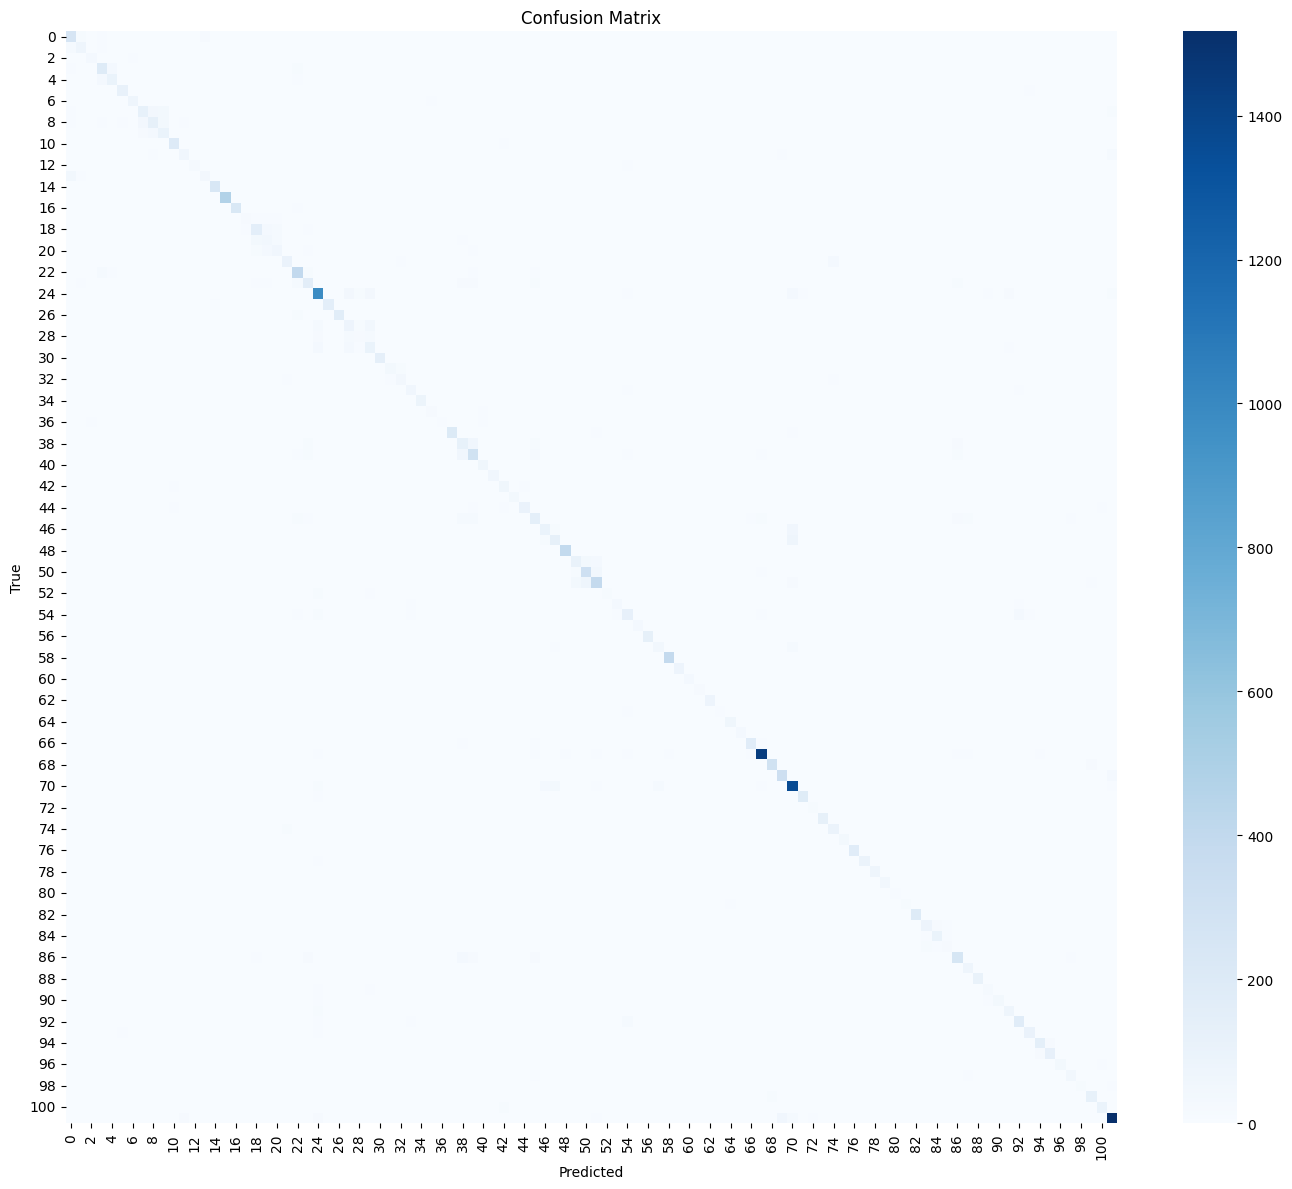

In [ ]:
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 12))
#sns.heatmap(conf_mat, cmap='Blues', xticklabels=False, yticklabels=False)
sns.heatmap(conf_mat, annot=False, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()





In [ ]:
worst_classes = df_report[df_report['recall'] < 0.3].sort_values('recall')
print("Worst Performing Classes", worst_classes[['precision', 'recall', 'f1-score']])

Worst Performing Classes     precision    recall  f1-score
52   0.307692  0.153846  0.205128
36   0.466667  0.218750  0.297872
28   0.297297  0.224490  0.255814


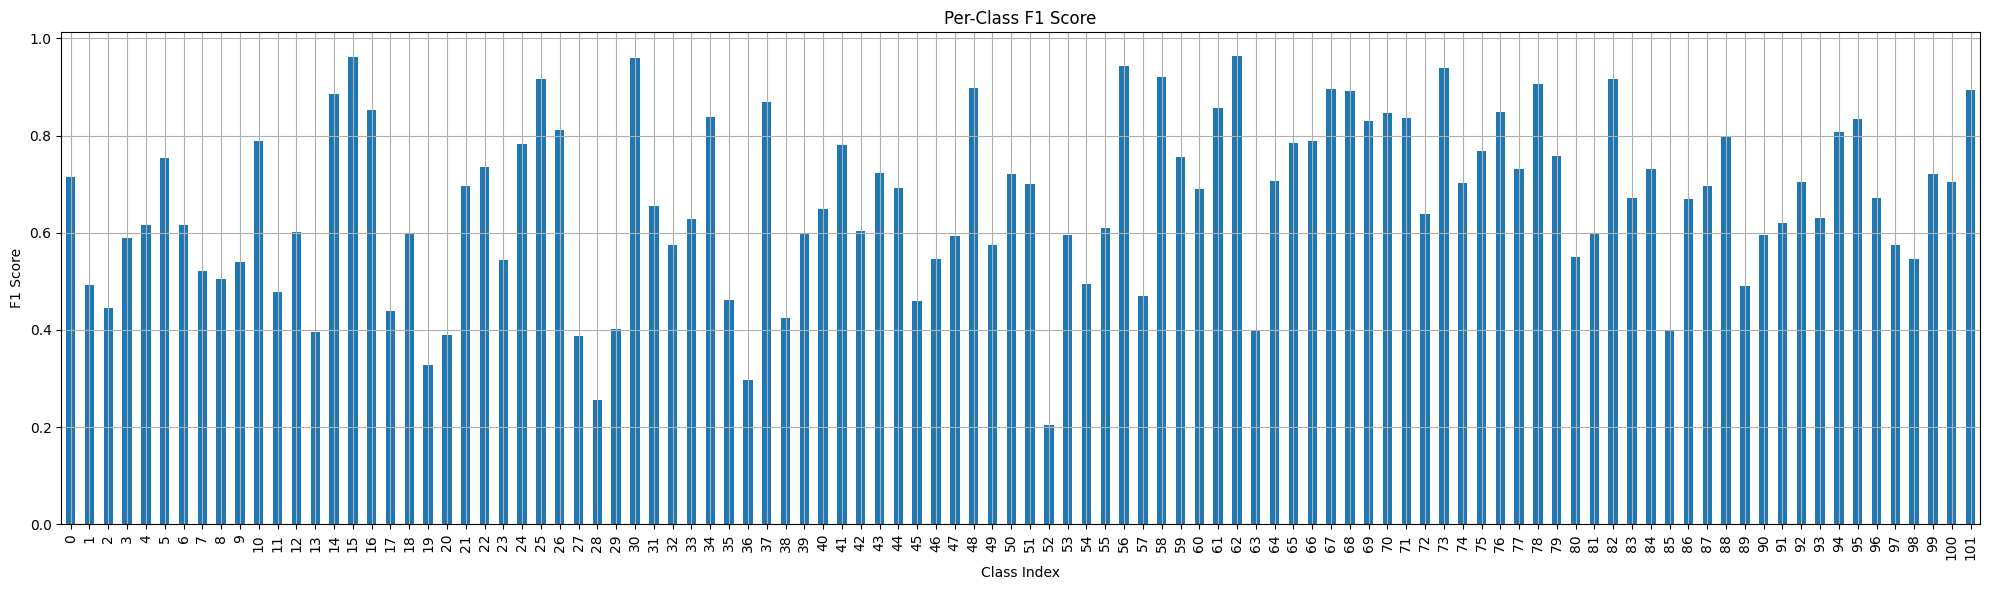

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_report is your DataFrame
df = df_report.iloc[:-3]  # Remove avg/accuracy

df["f1-score"].plot(kind="bar", figsize=(20, 6), title="Per-Class F1 Score")
plt.xlabel("Class Index")
plt.ylabel("F1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

/content/ip102dataset/test/class10/06575.jpg
10
<PIL.Image.Image image mode=RGB size=108x122 at 0x7C3476B89090>
11 rice water weevil


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


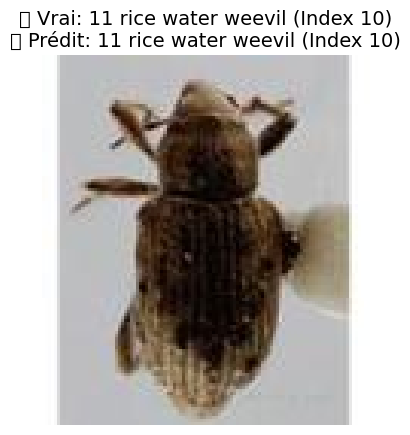

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from timm import create_model
import os
from timm.data import resolve_data_config, create_transform

# === 1. تحميل الكلاسات ===
with open('/content/ip102/Classification/classes.txt') as f:
    classes = [line.strip() for line in f]

# === 2. تحميل الموديل المدرب ===
checkpoint = torch.load("/content/drive/MyDrive/ip102_fastvit_v1_results/model_best.pth.tar", map_location="cpu")
model = create_model('fastvit_sa12', pretrained=False, num_classes=len(classes))
model.load_state_dict(checkpoint['state_dict'])
model.eval()

config = resolve_data_config({}, model=model)


# === 3. التحويلات ===
transform = create_transform(**config)

# === 4. تحديد مسار الصورة (اختر صورة من test) ===
image_rel_path = "class10/06575.jpg"  # مثال: الصورة موجودة داخل مجلد class 0
image_path = os.path.join("/content/ip102dataset/test/", image_rel_path)


# === 5. الحصول على الـ label الحقيقي من اسم المجلد (0 هنا)

class_folder = os.path.basename(os.path.dirname(image_path))  # 'class15'
true_idx = int(class_folder.replace('class', ''))


true_class = classes[true_idx]

# === 6. فتح الصورة وتطبيق transform
image = Image.open(image_path).convert('RGB')

print(image)
image_tensor = transform(image).unsqueeze(0)

# === 7. التنبؤ
with torch.no_grad():
    output = model(image_tensor)
    pred_idx = torch.argmax(output, dim=1).item()
    pred_class = classes[pred_idx]

print(pred_class)
# === 8. عرض النتائج
plt.imshow(image)
plt.title(f"✅ Vrai: {true_class} (Index {true_idx})\n🔮 Prédit: {pred_class} (Index {pred_idx})", fontsize=14)
plt.axis('off')
plt.show()



In [ ]:
from timm.data import resolve_data_config, create_transform

config = resolve_data_config({}, model=model)

In [ ]:
config

{'input_size': (3, 256, 256),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

/content/ip102dataset/test/class10/06575.jpg
10
<PIL.Image.Image image mode=RGB size=108x122 at 0x7C343C3C3D10>


In [ ]:
import numpy as np
img_array = np.array(image)

In [ ]:
img_array
image_tensor = transform(image).unsqueeze(0)


In [ ]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
from timm.data import create_dataset

dataset_test = create_dataset(
    "IP102val",
    root="/content/ip102dataset",
    split="test",
    is_training=False,
    batch_size=128,
    transform=transform,
)

In [ ]:
dataset_test.filename(2000)

'class10/06654.jpg'

In [ ]:
dataset_test[2000]

(tensor([[[0.3922, 0.4549, 0.4824,  ..., 0.5176, 0.5020, 0.4941],
          [0.3765, 0.4196, 0.4510,  ..., 0.5294, 0.5176, 0.5137],
          [0.3647, 0.3804, 0.4196,  ..., 0.5294, 0.5216, 0.5137],
          ...,
          [0.5176, 0.4784, 0.4431,  ..., 0.6784, 0.5765, 0.4824],
          [0.5059, 0.5020, 0.4941,  ..., 0.5490, 0.5333, 0.5373],
          [0.5216, 0.5137, 0.4941,  ..., 0.5373, 0.5020, 0.4902]],
 
         [[0.3804, 0.4431, 0.4706,  ..., 0.5216, 0.5059, 0.4980],
          [0.3647, 0.4078, 0.4392,  ..., 0.5333, 0.5216, 0.5176],
          [0.3529, 0.3686, 0.4078,  ..., 0.5333, 0.5255, 0.5176],
          ...,
          [0.5098, 0.4706, 0.4353,  ..., 0.5373, 0.4431, 0.3373],
          [0.4941, 0.4902, 0.4824,  ..., 0.3961, 0.3882, 0.3843],
          [0.5098, 0.5020, 0.4824,  ..., 0.3725, 0.3490, 0.3294]],
 
         [[0.3451, 0.4078, 0.4431,  ..., 0.4980, 0.4824, 0.4784],
          [0.3294, 0.3725, 0.4118,  ..., 0.5098, 0.4980, 0.4980],
          [0.3176, 0.3373, 0.3804,  ...,

In [ ]:
help(dataset_test)

Help on ImageDataset in module timm.data.dataset object:

class ImageDataset(torch.utils.data.dataset.Dataset)
 |  ImageDataset(root, reader=None, split='train', class_map=None, load_bytes=False, input_img_mode='RGB', transform=None, target_transform=None, **kwargs)
 |  
 |  Method resolution order:
 |      ImageDataset
 |      torch.utils.data.dataset.Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |  
 |  __init__(self, root, reader=None, split='train', class_map=None, load_bytes=False, input_img_mode='RGB', transform=None, target_transform=None, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  filename(self, index, basename=False, absolute=False)
 |  
 |  filenames(self, basename=False, absolute=False)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__

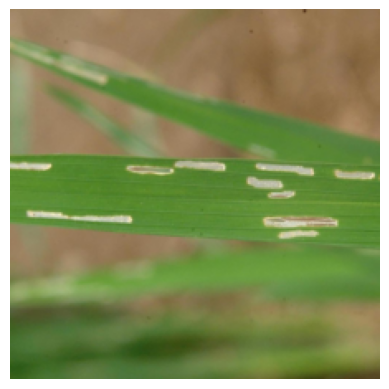

In [ ]:
import matplotlib.pyplot as plt

img = dataset_test[2001][0]
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

0

In [ ]:
image_path = dataset_test.fnames[0]

AttributeError: 'ImageDataset' object has no attribute 'fnames'

In [ ]:
type(dataset_test)

timm.data.dataset.ImageDataset